
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


Please be sure that all modules listed below are installed on your machine.

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.transforms
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats import weightstats as stests

### Global parameter to build seaborn boxplot

In [2]:
# If necessary, update the path where all data are located.
# All computed p-values are gathered in a CSV file saved in the folder 'path'
# whose file name depends on the experiment results you want to see
path = 'data/Test/'
offset_path = len(path)

# Comment or uncomment the following lines to see results (figures and p-values) for each conducted experiment
# Source code will be available on github soon...

file_name_lcs_1 = 'bacs-1-pep.json'
file_name_lcs_2 = 'bacs-2-pep.json'
file_name_lcs_3 = 'bacs-3-pep.json'

# Font size et figuresize parameters for plotting
figure_size = (20, 10)
axe_label_fontsize = '28'
tick_label_fontsize = '24'
legend_fontsize = '24'

# Significance level for p-values
alpha = 0.05

### Please, do not modify any lines of code below

### Reading json files

In [3]:
def read_json(path, file_name_lcs_1, file_name_lcs_2, file_name_lcs_3):
    json_data_from_lcs_1 = path + file_name_lcs_1
    json_data_from_lcs_2 = path + file_name_lcs_2
    json_data_from_lcs_3 = path + file_name_lcs_3
    json_data_from_lcs_4 = 'data/Test/acs2.json'

    with open(json_data_from_lcs_1) as json_file_1:
        raw_data_from_lcs_1 = json.load(json_file_1)

    with open(json_data_from_lcs_2) as json_file_2:
        raw_data_from_lcs_2 = json.load(json_file_2)

    with open(json_data_from_lcs_3) as json_file_3:
        raw_data_from_lcs_3 = json.load(json_file_3)

    with open(json_data_from_lcs_4) as json_file_4:
        raw_data_from_lcs_4 = json.load(json_file_4)

    raw_data = [raw_data_from_lcs_1,raw_data_from_lcs_2,raw_data_from_lcs_3,raw_data_from_lcs_4]
    lcs_name = [json_data_from_lcs_1[offset_path:-5], json_data_from_lcs_2[offset_path:-5], json_data_from_lcs_3[offset_path:-5],json_data_from_lcs_4[offset_path:-5]]
    return raw_data, lcs_name

# Call function to prepare plotting data
raw_data, lcs_name = read_json(path, file_name_lcs_1, file_name_lcs_2, file_name_lcs_3)

### Preparing pandas plotting data

In [4]:
def prepare_pandas_plotting_data(raw_data, lcs_name):
    cleaned_data = {
        'LCS':[], 
        'Maze':[], 
        'Knowledge (%)':[],
        'Population of classifiers':[], 
        'Reliable classifiers':[],
        'Average steps to exit':[],
    }
    nb_of_environments = 0
    for i in range(len(lcs_name)):
        for item in raw_data[i]:
            if 'time' not in item.keys():
                nb_of_environments += 1
                for idx in range(len(item['knowledge_list'])):
                    cleaned_data['LCS'].append(lcs_name[i])
                    if item['maze'][:-3] == "Woods101demi":
                        cleaned_data['Maze'].append("Woods101.5")
                    else:
                        cleaned_data['Maze'].append(item['maze'][:-3])
                    cleaned_data['Knowledge (%)'].append(item['knowledge_list'][idx])
                    cleaned_data['Population of classifiers'].append(item['population_list'][idx])
                    cleaned_data['Reliable classifiers'].append(item['reliable_list'][idx])
                    cleaned_data['Average steps to exit'].append(
                        item['avg_exploit_rl_list'][idx]
                    )

    nb_of_environments /= len(lcs_name)
    pandas_data = pd.DataFrame(cleaned_data)
    return nb_of_environments, pandas_data

nb_of_environments, pandas_data = prepare_pandas_plotting_data(raw_data, lcs_name)
pandas_data = pandas_data.sort_values(['Maze','LCS'])

### Plotting boxplots with seaborn

In [5]:
rc={
    'axes.labelsize':axe_label_fontsize,
    'xtick.labelsize':tick_label_fontsize,
    'ytick.labelsize':tick_label_fontsize
}
sns.set(context='paper', style='ticks', rc=rc)

In [6]:
def plot_figure(pandas_data, Y, legend_loc, lcs_name):
    
    # Build the main figure
    fig, ax = plt.subplots(figsize=figure_size)
    sns.stripplot(
        x = 'Maze',
        y = Y,
        hue = 'LCS',
        data = pandas_data,
        edgecolor='gray',
        jitter=True,
        linewidth = 1,
        dodge=True,
        palette='pastel',
        ax = ax
    )
    sns.boxplot(
        x = 'Maze',
        y = Y,
        hue = 'LCS',
        data = pandas_data,
        fliersize=0,
        palette='pastel',
        ax = ax
    )

    # Set up x tick labels and x label correctly
    plt.xticks(rotation = 45, horizontalalignment = 'right')
    plt.xlabel('')

    # Hide the horizontal gridlines
    ax.yaxis.grid(False)

    # Show the vertical gridlines
    ax.xaxis.grid(True)

    # Shift major ticks to create column for each maze
    plt.xticks(np.arange(nb_of_environments)+0.5)

    # Set up minor ticks and align label of major ticks on minor ticks
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    dx = (((figure_size[0] * 100 / 4.))/nb_of_environments - 10)/72.; dy = 0/72. # Width in inches converted into pixels depending on default DPI
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() - offset)

    # Set up legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:len(lcs_name)], labels[0:len(lcs_name)], frameon=False, loc=legend_loc, fontsize=legend_fontsize)

In [7]:
def plot_knowledge(pandas_data, zipped:bool=True):
    plot_figure(pandas_data, Y='Knowledge (%)', legend_loc='lower right', lcs_name=lcs_name)
    
def plot_population(pandas_data, only_reliable:bool=False):
    if not only_reliable:
        Y = 'Population of classifiers'
    else:
        Y = 'Reliable classifiers'
    plot_figure(pandas_data, Y=Y, legend_loc='upper right', lcs_name=lcs_name)

def plot_avg_steps_to_exit(pandas_data):
    plot_figure(pandas_data, Y='Average steps to exit', legend_loc='upper right', lcs_name=lcs_name)

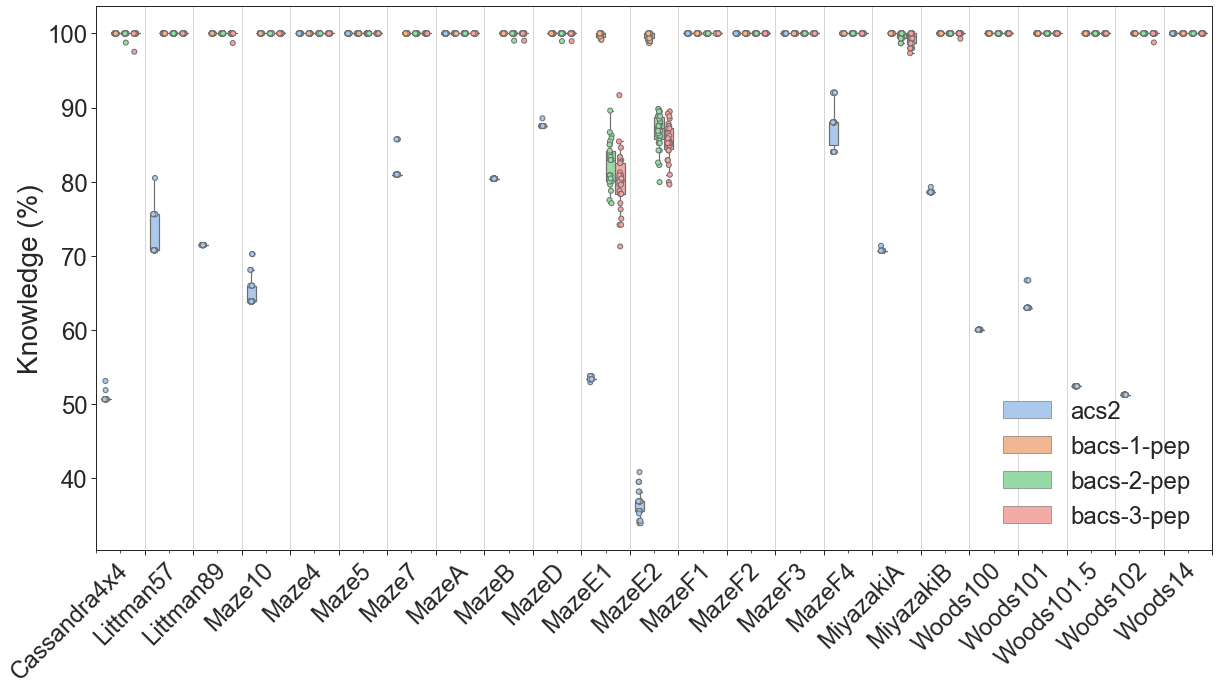

In [8]:
plot_knowledge(pandas_data)

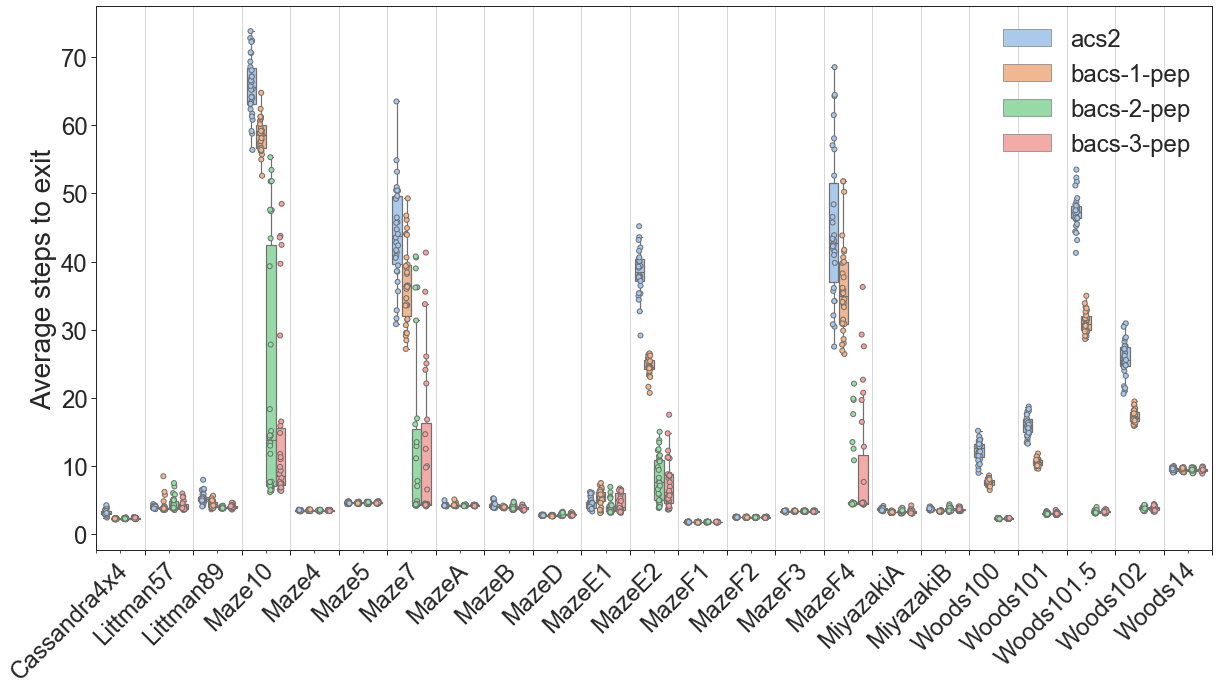

In [9]:
plot_avg_steps_to_exit(pandas_data)

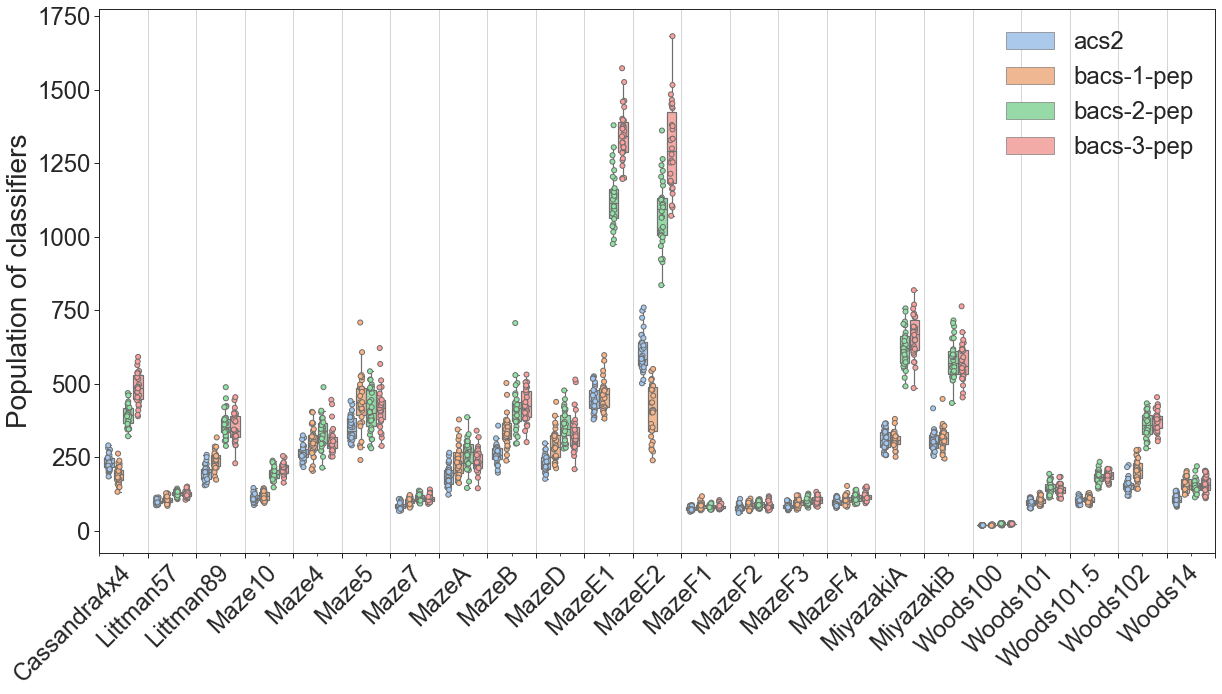

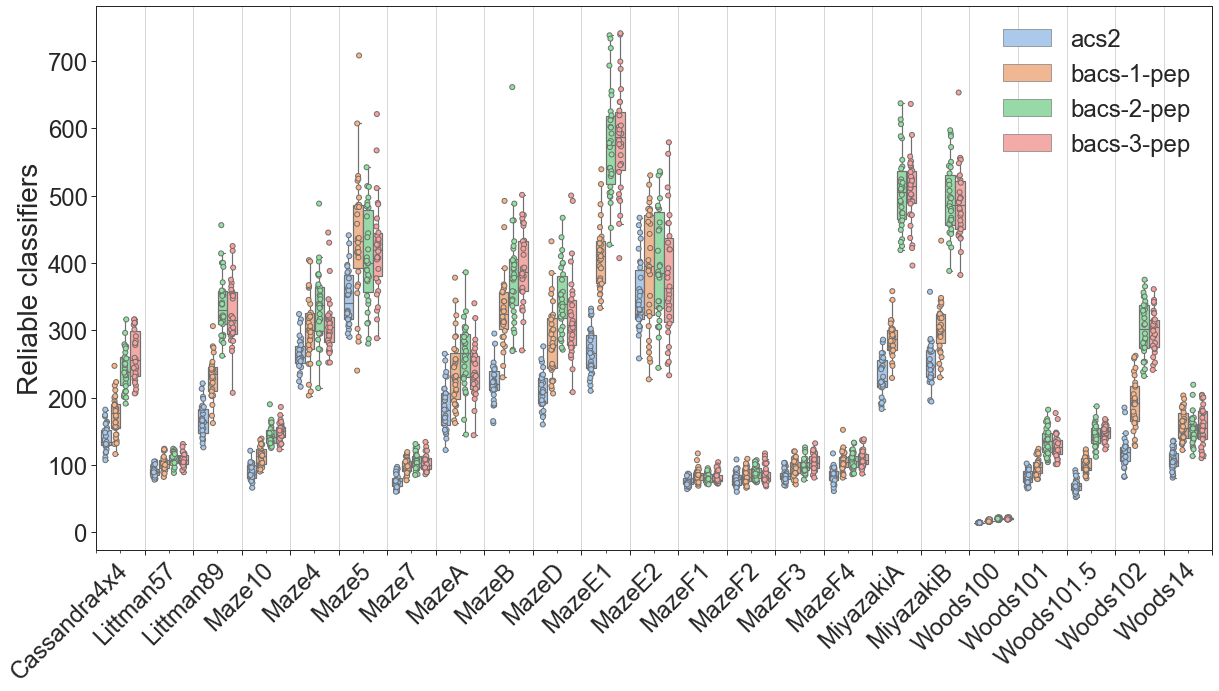

In [10]:
#plot_population(pandas_data, only_reliable=False)
#plot_population(pandas_data, only_reliable=True)

### Preparing statistical data from raw read json

In [11]:
raw_list_by_env_name = {}
for i in range(len(lcs_name)):
    for item in raw_data[i]:
        if 'time' not in item.keys():
            if item['maze'] not in raw_list_by_env_name.keys():
                raw_list_by_env_name[item['maze']] = {
                    'knowledge_list' : [],
                    'population_list' : [],
                    'reliable_list' : [],
                    'avg_exploit_no_rl_list' : [],
                    'avg_exploit_rl_list' : [],
                    'mean_reliable_classifier_specificity_list' : []
                }
            raw_list_by_env_name[item['maze']]['knowledge_list'].append(
                np.array(item['knowledge_list']))
            raw_list_by_env_name[item['maze']]['population_list'].append(
                np.array(item['population_list']))
            raw_list_by_env_name[item['maze']]['reliable_list'].append(
                np.array(item['reliable_list']))
            raw_list_by_env_name[item['maze']]['mean_reliable_classifier_specificity_list'].append(
                np.array(item['mean_reliable_classifier_specificity_list']))
            raw_list_by_env_name[item['maze']]['avg_exploit_rl_list'].append(
                np.array(item['avg_exploit_rl_list']))

KeyError: 'mean_reliable_classifier_specificity_list'

### Computing p-values

In [ ]:
raw_statistical_data = {
    'Maze':[],
    'Metric':[],
    'Alternative':[],
    'Degrees of freedom':[],
    'P Value':[],
    'Null Hypothesis':[]
}
for env_name in raw_list_by_env_name.keys():
    for metric in raw_list_by_env_name[env_name].keys():
        if metric != "avg_exploit_no_rl_list":
            for i in range(3):
                raw_statistical_data['Maze'].append(env_name)
                raw_statistical_data['Metric'].append(metric)
                x1 = np.array(raw_list_by_env_name[env_name][metric][0])
                x2 = np.array(raw_list_by_env_name[env_name][metric][1])
                if i == 0:
                    alt = 'two-sided'
                elif i == 1:
                    alt = 'larger'
                else:
                    alt = 'smaller'
                raw_statistical_data['Alternative'].append(alt)
                tstats, pvalue, dof = stests.ttest_ind(x1, x2, alternative=alt, usevar='unequal', value=0)
                raw_statistical_data['Degrees of freedom'].append(dof)
                raw_statistical_data['P Value'].append(pvalue)
                if pvalue<alpha:
                    raw_statistical_data['Null Hypothesis'].append('Reject')
                else:
                    raw_statistical_data['Null Hypothesis'].append('Accept')
statistical_pandas = pd.DataFrame(raw_statistical_data)

In [ ]:
#statistical_pandas.to_csv(path + lcs_name[0] + '_&_' + lcs_name[1] + '_stats.csv')